# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Imports and Functions

In [ ]:
import seaborn as sns
import pandas as pd
from scipy.stats import skew, kurtosis

def get_data_frame(filename):
    CSV_FOLDER_NAME = "Robotic Arm"
    csv_filepath = os.path.join(CSV_FOLDER_NAME, filename)
    return pd.read_csv(csv_filepath)

def plot_corr_matrix(data):
    corr = data.corr()
    plt.figure(figsize=(25, 20))
    sns.heatmap(corr, annot=True,mask=np.triu(corr), cmap='coolwarm', fmt='.2f')
    plt.title("Correlation Matrix")
    plt.show() 

def add_time_column(df):
    df['time'] = pd.to_datetime(df['time'], unit='ns')
    df.set_index('time', inplace=True)
    return df

def extract_rolling_features(df):
    sensor_cols = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ', 'magX', 'magY', 'magZ']

    # Use a rolling window of 1 second and extraxt key features
    features_df = df[sensor_cols].rolling(window='1S').agg(['mean', 'std'])

    # Flatten MultiIndex
    features_df.columns = ['_'.join(col).strip() for col in features_df.columns]
    
    # Remove nan (to be sure)
    features_df = features_df.dropna().reset_index(drop=True)
    
    return features_df

def resample_to_10Hz(df):
    # Behold kun numeriske kolonner for resampling
    df_numeric = df.select_dtypes(include=[np.number])

    # Resample til target frequency (10Hz = 100ms)
    df_resampled = df_numeric.resample("100ms").mean().dropna()
    return df_resampled

# Explore the Data

In [61]:
raw_data = get_data_frame("IMU_10Hz.csv")
raw_data.head()

,name,time,accX,accY,accZ,gyroX,gyroY,gyroZ,magX,magY,magZ
0,IMU8,1686062828391000000,9.773131,0.232238,0.490811,-0.1250,0.0000,0.0,0.000000,0.00,0.000000
1,IMU8,1686062828537000000,9.806650,0.263362,0.488417,0.0625,0.0000,0.0,-48.279999,-7.44,-13.230769
2,IMU8,1686062828585000000,9.794679,0.251391,0.442927,-0.1875,0.0000,0.0,-48.560001,-7.48,-13.230769
3,IMU8,1686062828682000000,9.770737,0.222661,0.445322,-0.0625,0.0625,0.0,-48.520000,-7.32,-13.461538
4,IMU8,1686062828780000000,9.792285,0.222661,0.464475,0.0000,0.0000,0.0,-48.360001,-7.28,-13.692307


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 874937 entries, 0 to 874936
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   name    874937 non-null  object 
 1   time    874937 non-null  int64  
 2   accX    874937 non-null  float64
 3   accY    874937 non-null  float64
 4   accZ    874937 non-null  float64
 5   gyroX   874937 non-null  float64
 6   gyroY   874937 non-null  float64
 7   gyroZ   874937 non-null  float64
 8   magX    874937 non-null  float64
 9   magY    874937 non-null  float64
 10  magZ    874937 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 73.4+ MB


In [62]:
raw_data = add_time_column(raw_data)
raw_data.head()

,name,accX,accY,accZ,gyroX,gyroY,gyroZ,magX,magY,magZ
time,,,,,,,,,,
2023-06-06 14:47:08.391,IMU8,9.773131,0.232238,0.490811,-0.1250,0.0000,0.0,0.000000,0.00,0.000000
2023-06-06 14:47:08.537,IMU8,9.806650,0.263362,0.488417,0.0625,0.0000,0.0,-48.279999,-7.44,-13.230769
2023-06-06 14:47:08.585,IMU8,9.794679,0.251391,0.442927,-0.1875,0.0000,0.0,-48.560001,-7.48,-13.230769
2023-06-06 14:47:08.682,IMU8,9.770737,0.222661,0.445322,-0.0625,0.0625,0.0,-48.520000,-7.32,-13.461538
2023-06-06 14:47:08.780,IMU8,9.792285,0.222661,0.464475,0.0000,0.0000,0.0,-48.360001,-7.28,-13.692307


In [6]:
# Look for missing data
missing_data = raw_data.isna().sum().sum()
print(f"Amount of missing data: {missing_data}") 

Amount of missing data: 0


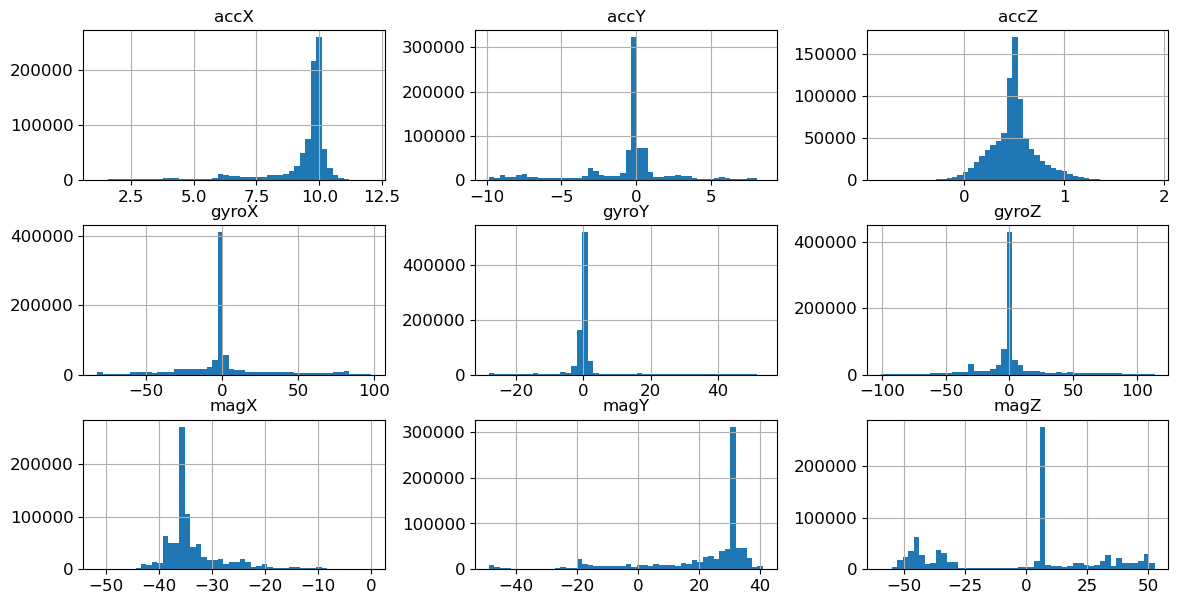

In [9]:
raw_data.hist(bins=50, figsize=(14,7))
plt.show()

In [63]:
# Split normal data into test and train using a ratio to improve speed
ratio_train = 0.5

split_idx = int(len(raw_data) * ratio_train)

# Split the data
train_data = raw_data[:split_idx]
test_data = raw_data[split_idx:] 

print(f'Length train: {len(train_data)}')
print(f'Length test: {len(test_data)}')

Length train: 437468
Length test: 437469


In [64]:
# Resample to 10Hz
df_resampled = resample_to_10Hz(train_data)
df_resampled = train_data # TODO: Testing

# Extract rolling features
X_normal = extract_rolling_features(df_resampled)

X_normal.head()

,accX_mean,accX_std,accY_mean,accY_std,accZ_mean,accZ_std,gyroX_mean,gyroX_std,gyroY_mean,gyroY_std,gyroZ_mean,gyroZ_std,magX_mean,magX_std,magY_mean,magY_std,magZ_mean,magZ_std
0,9.789891,0.023701,0.247800,0.022008,0.489614,0.001693,-0.031250,0.132583,0.000000,0.000000,0.0,0.0,-24.139999,34.139115,-3.720000,5.260874,-6.615385,9.355567
1,9.791487,0.016986,0.248997,0.015700,0.474052,0.026981,-0.083333,0.130104,0.000000,0.000000,0.0,0.0,-32.280000,27.955651,-4.973333,4.307079,-8.820513,7.638788
2,9.786299,0.017320,0.242413,0.018377,0.466869,0.026300,-0.078125,0.106739,0.015625,0.031250,0.0,0.0,-36.340000,24.226982,-5.560000,3.707290,-9.980769,6.654735
3,9.787496,0.015237,0.238462,0.018202,0.466390,0.022802,-0.062500,0.098821,0.012500,0.027951,0.0,0.0,-38.744000,21.658857,-5.904000,3.301466,-10.723077,5.997435
4,9.787496,0.013628,0.239420,0.016449,0.472057,0.024669,-0.072917,0.091998,0.000000,0.039528,0.0,0.0,-40.320000,19.753165,-6.180000,3.029323,-11.269231,5.528570


# Scaling the Data

In [65]:
from sklearn.preprocessing import StandardScaler

# Create scaler
scaler = StandardScaler()
X_normal_scaled = scaler.fit_transform(X_normal)

# Train Gaussian Mixture

In [ ]:
from sklearn.mixture import GaussianMixture

# Tune number of components
n_components = 6 # TODO: Use a shiluette diagram fo choose

# Train the model on normal data
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=21)
gmm.fit(X_normal_scaled)

GaussianMixture(n_components=6, random_state=21)

Define threshold

In [181]:
# Calculate threshold
log_likelihood_train = gmm.score_samples(X_normal_scaled)
threshold = np.percentile(log_likelihood_train, 0.5)

# Testing

In [182]:
def print_mean_LogLikelihood(filename, gmm, scaler, resample_to_10Hz=False):
    # Get the data from csv
    df = get_data_frame(filename)

    # Add pandas time
    df = add_time_column(df)

    # Resample to 10Hz to keep concistancy
    if resample_to_10Hz:
        df = resample_to_10Hz(df)

    # Extract rolling features
    X_data = extract_rolling_features(df)

    # Scale the data using the existing scaler
    X_data_scaled = scaler.transform(X_data)

    # Calculate log-likelihood and anomalies
    log_likelihood = gmm.score_samples(X_data_scaled)

    return log_likelihood.mean()

In [183]:
print_mean_LogLikelihood("IMU_10Hz.csv", gmm, scaler)

10.042092884739272

In [ ]:
print_mean_LogLikelihood("IMU_earthquake.csv", gmm, scaler)

-299.8984573399923

In [ ]:
print_mean_LogLikelihood("IMU_20Hz_freq_drop.csv", gmm, scaler)

-18.244215977502357

In [ ]:
print_mean_LogLikelihood("IMU_20Hz_freq_drop_2.csv", gmm, scaler)

-16.305012057141134

In [ ]:
print_mean_LogLikelihood("IMU_hitting_platform.csv", gmm, scaler)

-64.10990593022757

In [ ]:
print_mean_LogLikelihood("IMU_extra_weigth.csv", gmm, scaler)

-35.99937323146703

# Visualize Anomaly Detection

In [184]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

def plot_anomalies_histogram(filename, threshold, gmm, scaler, x_start=-500, x_end=50, resample_10Hz=False):
    # Get the data from csv
    df = get_data_frame(filename)

    # Add pandas time
    df = add_time_column(df)

    if resample_10Hz:
        # Resample to 10Hz to keep consistency
        df = resample_to_10Hz(df)

    # Extract rolling features
    X_data = extract_rolling_features(df)

    # Scale the data using the existing scaler
    X_data_scaled = scaler.transform(X_data)

    # Calculate log-likelihood and anomalies
    log_likelihood = gmm.score_samples(X_data_scaled)

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(log_likelihood, bins=100, color='gray', alpha=0.7, label="Log-Likelihood", edgecolor='black', density=True)

    # KDE (Kernel Density Estimate) for the distribution
    kde = gaussian_kde(log_likelihood, bw_method='silverman')
    x_range = np.linspace(min(log_likelihood), max(log_likelihood), 1000)
    kde_values = kde(x_range)

    # Shaded region under the KDE curve
    plt.fill_between(x_range, kde_values, color='blue', alpha=0.2, label="Density")

    # Add a vertical line for anomaly threshold
    plt.axvline(threshold, color='coral', linestyle='dashed', linewidth=3, label="0.5 % Likelihood")

    # Add a vertical line for mean Log-Likelihood
    plt.axvline(log_likelihood.mean(), color='blue', linestyle='-', linewidth=2, label="Mean Log-Likelihood")

    # Add labels and title
    plt.xlabel('Log-Likelihood')
    plt.ylabel('Density')
    plt.title('Histogram of Log-Likelihood with Anomalies and KDE Distribution')
    plt.legend()

    plt.xlim(x_start, x_end)

    # Show plot
    plt.show()

### If the mean is below the 0.5 % likelihood threshold, it is less than 0.5 % likely this happens. 

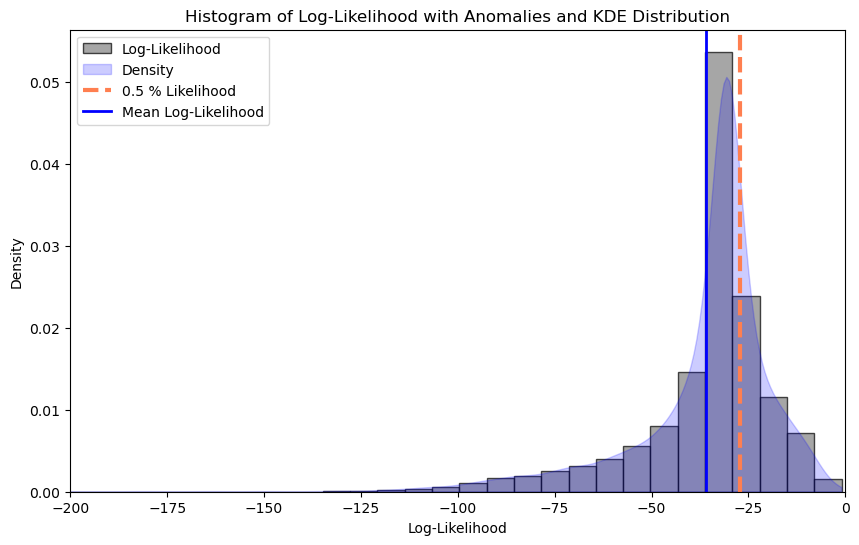

In [ ]:
plot_anomalies_histogram("IMU_extra_weigth.csv", threshold, gmm, scaler, x_start=-200, x_end=0)

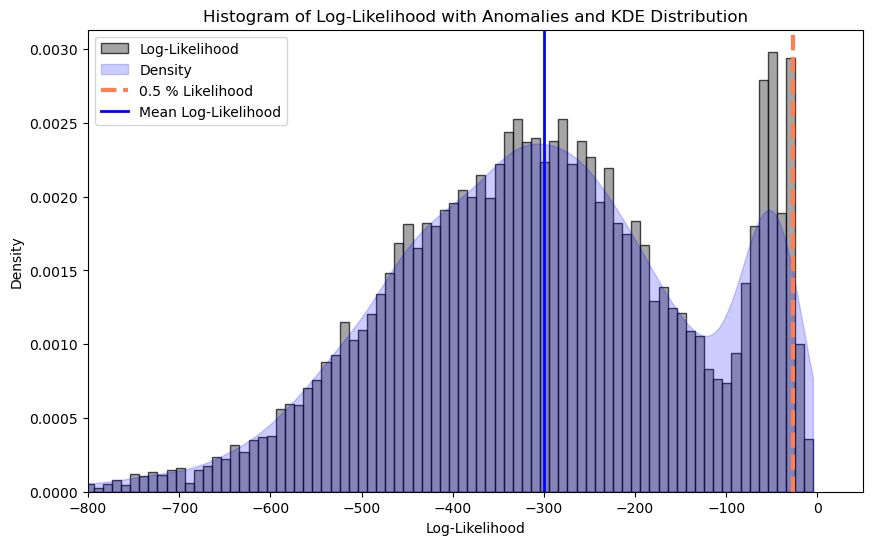

In [ ]:
plot_anomalies_histogram("IMU_earthquake.csv", threshold, gmm, scaler, x_start=-800)

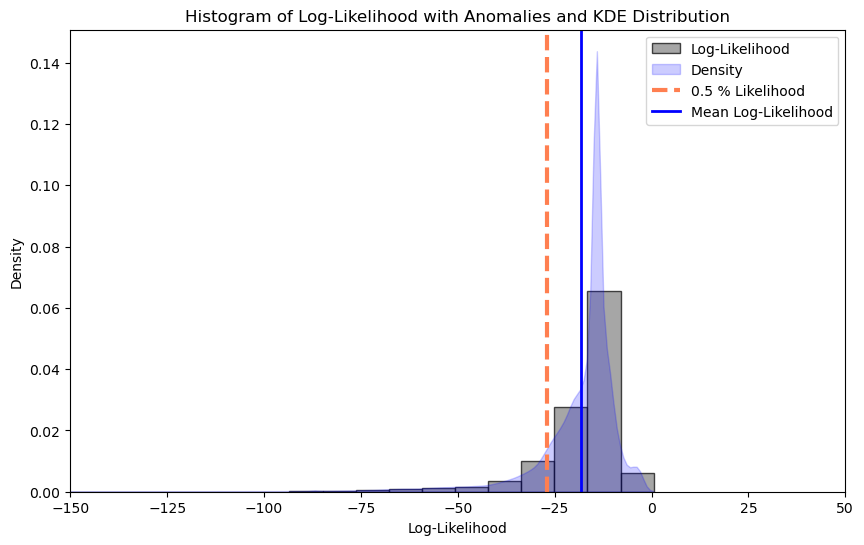

In [185]:
plot_anomalies_histogram("IMU_20Hz_freq_drop.csv", threshold, gmm, scaler, x_start=-150, x_end=50)

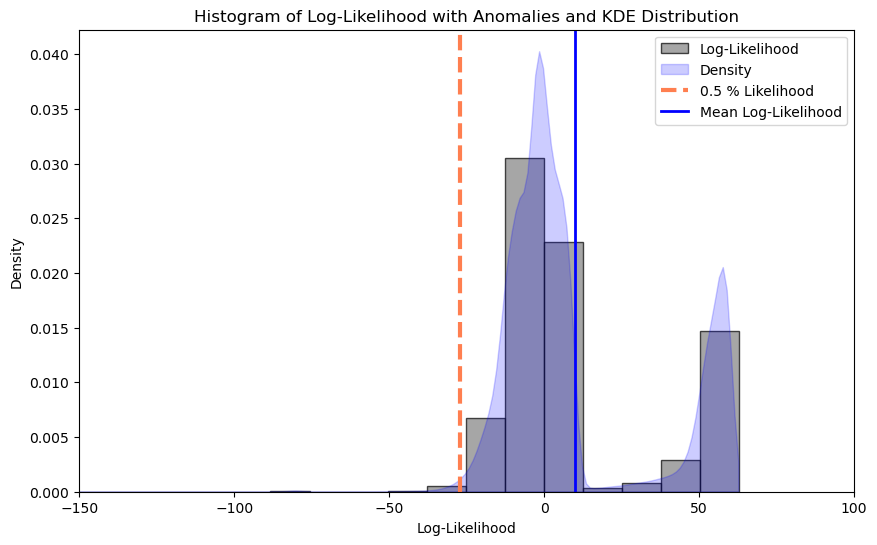

In [ ]:
plot_anomalies_histogram("IMU_10Hz.csv", threshold, gmm, scaler, x_start=-150, x_end=100)

In [178]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def plot_log_likelihood_timeseries(filename, threshold, gmm, scaler, resample_10Hz=True):
    # Get the data from csv
    df = get_data_frame(filename)

    # Add pandas time
    df = add_time_column(df)

    if resample_10Hz:
        # Resample to 10 Hz
        df = resample_to_10Hz(df)

    # Extract rolling features
    X_data = extract_rolling_features(df)

    # Scalse the data
    X_data_scaled = scaler.transform(X_data)

    # Calculate log-likelihood and anomalies globally
    log_likelihood = gmm.score_samples(X_data_scaled)
    anomalies = log_likelihood < threshold

    # Get time values
    time_values = df.index  

    # Interactive widgets
    start_slider = widgets.IntSlider(value=0, min=0, max=len(time_values)-100, step=10, description='Start:')
    window_slider = widgets.IntSlider(value=500, min=100, max=5000, step=100, description='Window:')

    def update_plot(start, window):
        # Define plot end
        end = min(start + window, len(time_values))

        # Anomaly fraction of current time window
        log_likelihood_mean = log_likelihood[start:end].mean()

        # Update new plot
        plt.figure(figsize=(12, 6))
        plt.plot(time_values[start:end], log_likelihood[start:end], label="Log-Likelihood", color="gray")
        # plt.scatter(time_values[start:end][anomalies[start:end]], 
        #             log_likelihood[start:end][anomalies[start:end]], 
        #             color='black', label="Anomalies", zorder=3, s=3)
        
        plt.axhline(threshold, color='coral', linestyle='dashed', linewidth=3, label="0.5 % Likelihood")

        plt.axhline(log_likelihood_mean, color='blue', linestyle='-', linewidth=2, label="Mean Log-Likelihood (current window)")


        # Display current anomaly fraction
        text_str = f"Mean Log-Likelihood (current window): {log_likelihood_mean:.2f}"
        plt.text(0.02, 0.05, text_str, transform=plt.gca().transAxes, 
                 fontsize=12, verticalalignment='top', 
                 bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

        plt.xlabel("Time")
        plt.ylabel("Log-Likelihood")
        plt.title("Log-Likelihood Timeseries " + filename)
        plt.legend(loc='lower right')
        plt.grid()
        plt.show()

    # Make interactive plot
    interactive_plot = widgets.interactive(update_plot, start=start_slider, window=window_slider)
    display(interactive_plot)

In [ ]:
plot_log_likelihood_timeseries("IMU_extra_weigth.csv", threshold, gmm, scaler)


interactive(children=(IntSlider(value=0, description='Start:', max=10093, step=10), IntSlider(value=500, descr…

In [ ]:
plot_log_likelihood_timeseries("IMU_20Hz_freq_drop.csv", threshold, gmm, scaler)

interactive(children=(IntSlider(value=0, description='Start:', max=857981, step=10), IntSlider(value=500, desc…

# DBSCAN

In [13]:
from sklearn.cluster import DBSCAN

cut_start = X_normal_scaled[10000:]
dbscan_train = cut_start[:20000]

db = DBSCAN(eps=3, min_samples=200).fit(dbscan_train)

In [14]:
labels = db.fit_predict(dbscan_train)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters)

2


In [ ]:
def print_dbscan_anomalies(scaled_test_data):
    labels_new = db.fit_predict(scaled_test_data)
    anomaly_ratio = np.sum(labels_new == -1) / len(labels_new)
    print(f"Andel anomalier i den nye tidsserien: {anomaly_ratio:.2%}")

print_dbscan_anomalies(dbscan_train)

Andel anomalier i den nye tidsserien: 3.02%


In [16]:
def get_processed_data(filename):
    df = get_data_frame(filename)
    df = add_time_column(df)
    df = resample_to_10Hz(df)
    X_data = extract_rolling_features(df)
    X_data_scaled = scaler.transform(X_data)
    return X_data_scaled


earthquake_data_scaled = get_processed_data("IMU_earthquake.csv")

print_dbscan_anomalies(earthquake_data_scaled)

Andel anomalier i den nye tidsserien: 22.05%
